# Multilevel Quantum Circuit Partitioning

This notebook explores the multilevel framework in some more depth and briefly comparese the different coarsening routines. This follows on from the "walkthrough" notebook.

In [ ]:
from disqco.circuits.cp_fraction import cp_fraction
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from qiskit import transpile
from disqco.parti.FM.FM_methods import set_initial_partitions,calculate_full_cost
from qiskit.circuit.library import QFT, QuantumVolume, EfficientSU2
from disqco.circuits.QAOA import QAOA_random
import numpy as np
import time
from disqco.graphs.quantum_network import QuantumNetwork

num_qubits = 32
num_partitions = 4
qpu_size = int(num_qubits / num_partitions) + 1
qpu_sizes = [qpu_size] * num_partitions

network = QuantumNetwork(qpu_sizes)


circuit = cp_fraction(  num_qubits=num_qubits,
                        depth=2*num_qubits,
                        fraction= 0.3)

circuit = transpile(circuit, basis_gates = ['cp', 'u'])
depth = circuit.depth()

graph = QuantumCircuitHyperGraph(circuit, group_gates = True, anti_diag = True)
assignment = set_initial_partitions(network, num_qubits, depth, num_partitions)




initial_cost = calculate_full_cost(graph, assignment, num_partitions)


The jupyter_tikz extension is already loaded. To reload it, use:
  %reload_ext jupyter_tikz


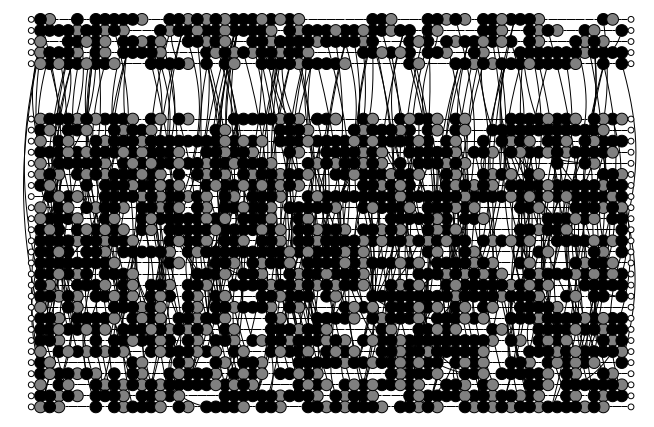

In [51]:
from disqco.drawing.tikz_drawing import draw_graph_tikz
%load_ext jupyter_tikz

draw_graph_tikz(graph, assignment, qpu_sizes)

We first run the normal FM algorithm, with no coarsening, to set a benchmark. We will use the depth of the circuit to calculate the number of passes we will use, for fairness of comparison. We will set a limit on the number of nodes that can be moved per pass.

In [ ]:
from disqco.parti.FM.FM_main import run_FM

level_limit = int(np.ceil(np.log2(depth)))

num_passes = (level_limit+1) * 10
move_limit_per_pass = len(graph.nodes)*0.125
exploratory = True

start = time.time()
final_cost, final_assignment, cost_list = run_FM(
    graph,
    assignment,
    qpu_sizes,
    limit=move_limit_per_pass,
    passes=num_passes,
    add_initial=True,
    stochastic=exploratory
)

end = time.time()
print("Final cost: ", final_cost)
print("Time taken: ", end-start)



Initial cost: 291
All passes complete.
Final cost: 232


In [53]:
from disqco.parti.FM.multilevel_FM import *
from disqco.graphs.coarsening.coarsener import HypergraphCoarsener

coarsener = HypergraphCoarsener()

initial_graph_full = graph.copy()

graph_list, mapping_list = coarsener.coarsen_full(initial_graph_full, num_levels = depth)

coarsest_graph = graph_list[-1]



We start by coarsening the graph down to a single time-step, to see how we well can do with static partitioning. The initialisation and termination nodes are included in the figure but are not part of the actual graph.

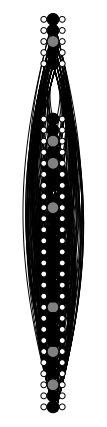

In [54]:
fig = draw_graph_tikz(
    coarsest_graph,
    assignment,
    qpu_sizes
)

display(fig)

In [ ]:
start = time.time()
final_cost, final_assignment, cost_list = run_FM(coarsest_graph, assignment, qpu_sizes, limit=move_limit_per_pass, max_gain=4*depth, passes=num_passes, log=False)
end = time.time()

print("Time taken for coarsest graph: ", end-start)


Initial cost: 291
All passes complete.
Final cost: 236
Time taken for coarsest graph:  1.5527961254119873


Static partitioning will be much faster, and, in some cases, static partitioning can outperform the fine-grained approach, since the problem size is smaller, but it will often be limited since no state teleportation is possible. We will now look at a multilevel approach using a window-based coarsening routine.

Best cost: 204
Total time: 3.726386070251465
Drawing figures


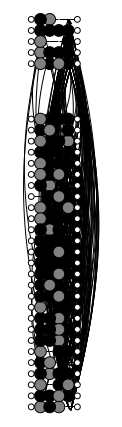

Cost at level 1, 262


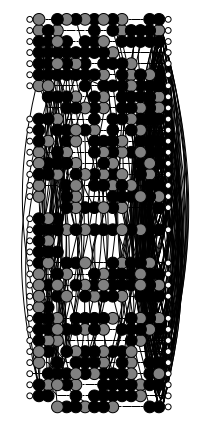

Cost at level 2, 252


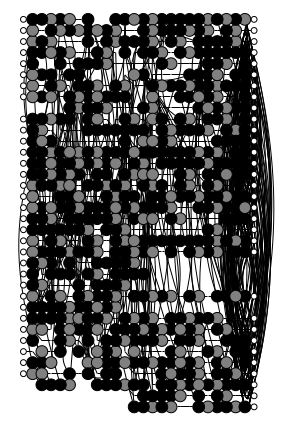

Cost at level 3, 234


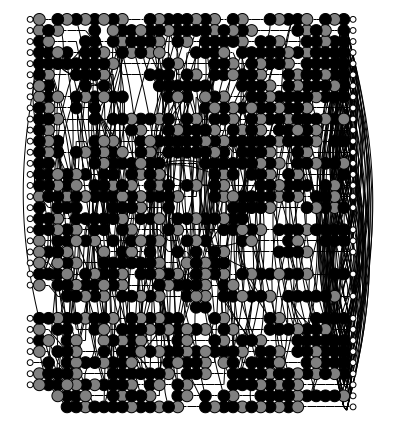

Cost at level 4, 227


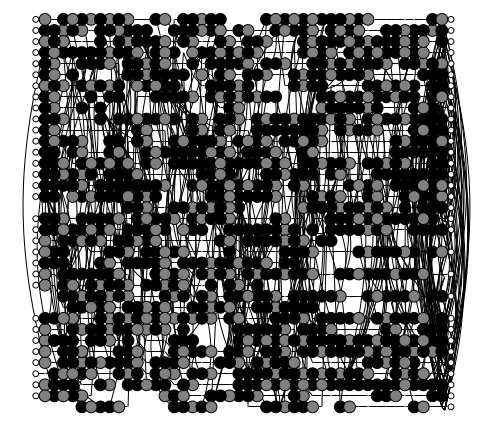

Cost at level 5, 218


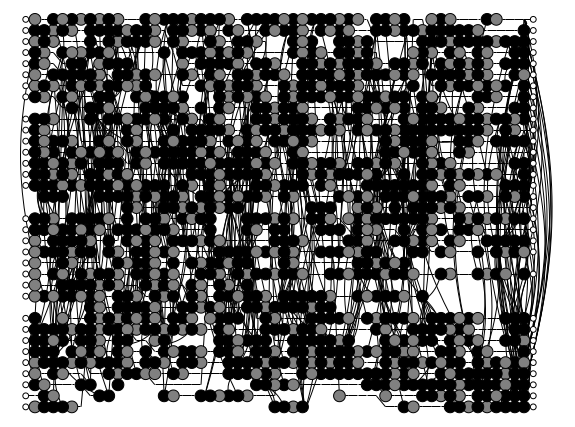

Cost at level 6, 210


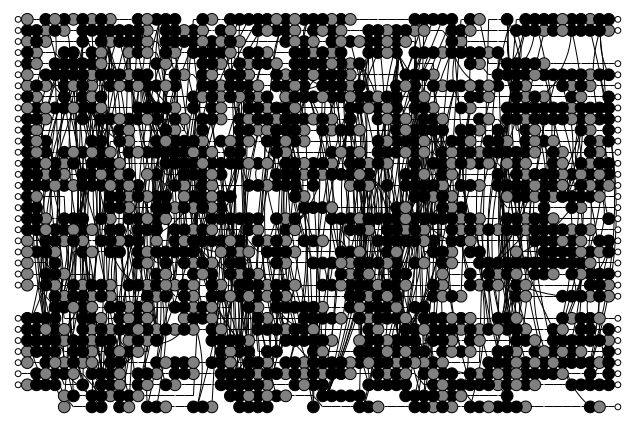

Cost at level 7, 204


In [56]:
initial_graph_window = graph.copy()

graph_list_window, mapping_list_window = coarsener.coarsen_full(initial_graph_window, num_levels = level_limit)


assignment_list_window, cost_list_window, time_list_window = multilevel_FM(graph_list_window, mapping_list_window, assignment, qpu_sizes, limit=move_limit_per_pass, stochastic=exploratory)

best_cost = min(cost_list_window)
total_time = sum(time_list_window)

print(f'Best cost: {best_cost}')
print(f'Total time: {total_time}')

i = 0
print("Drawing figures")
for g in reversed(graph_list_window):
    fig = draw_graph_tikz(
        g,
        assignment_list_window[i],
        qpu_sizes
    )
    display(fig)
    i += 1
    print(f'Cost at level {i}, {calculate_full_cost(g, assignment_list_window[i], num_partitions)}')

Best cost: 204
Total time: 3.7901954650878906
Drawing figures


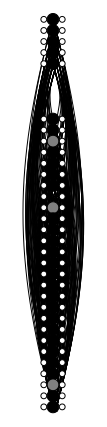

Cost at level 0, 291


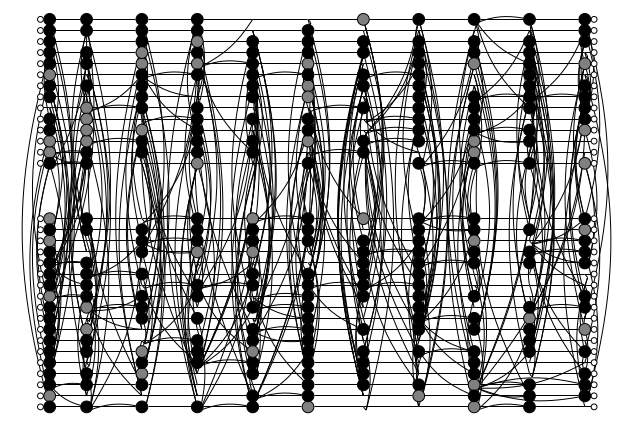

Cost at level 1, 241


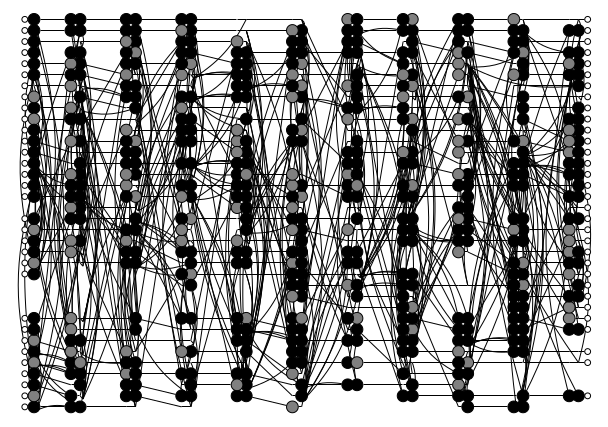

Cost at level 2, 239


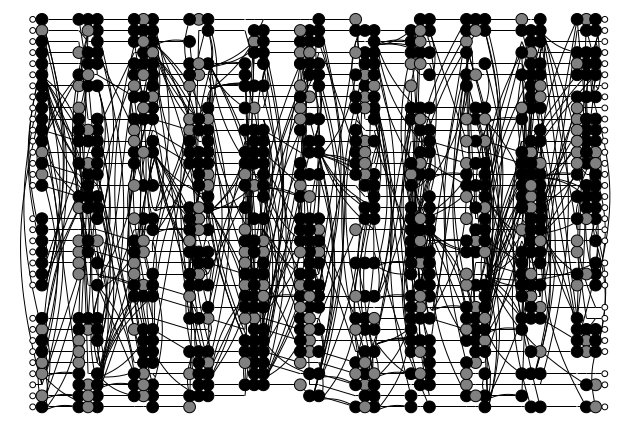

Cost at level 3, 222


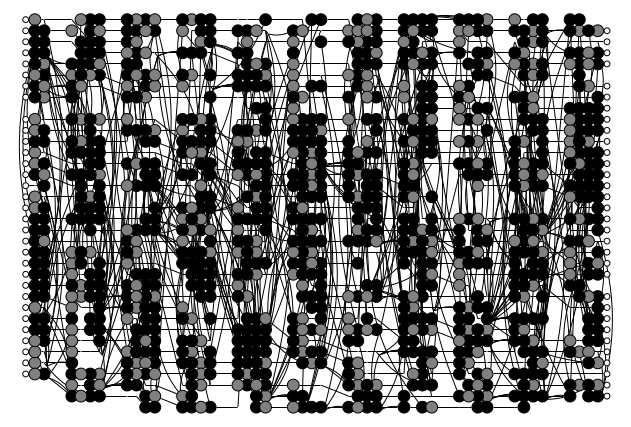

Cost at level 4, 213


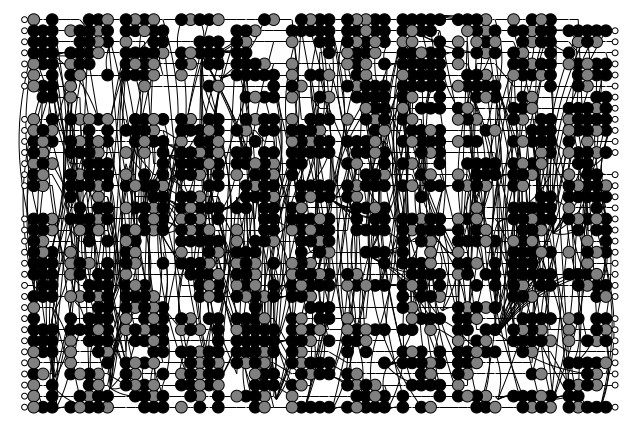

Cost at level 5, 207


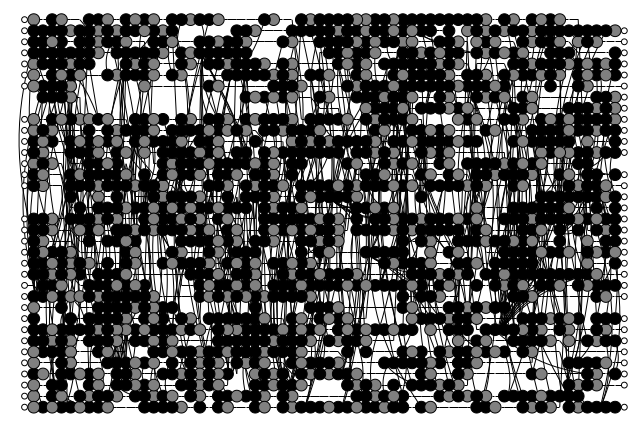

Cost at level 6, 207


In [57]:
initial_graph_blocks = graph.copy()

graph_list_blocks, mapping_list_blocks = coarsener.coarsen_blocks(initial_graph_blocks, num_blocks= None, block_size = level_limit)

assignment_list_blocks, cost_list_blocks, time_list_blocks = multilevel_FM(graph_list_blocks, mapping_list_blocks, assignment, qpu_sizes, limit=move_limit_per_pass, stochastic=exploratory)
i = 0

best_cost = min(cost_list_blocks)
total_time = sum(time_list_blocks)

print(f'Best cost: {best_cost}')
print(f'Total time: {total_time}')

print("Drawing figures")

for g in reversed(graph_list_blocks):
    fig = draw_graph_tikz(
        g,
        assignment_list_blocks[i],
        qpu_sizes
    )
    display(fig)
    print(f'Cost at level {i}, {cost_list_blocks[i]}')
    i += 1

Best cost: 209
Total time: 4.365983486175537
Drawing figures


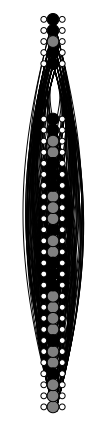

Cost at level 0, 291


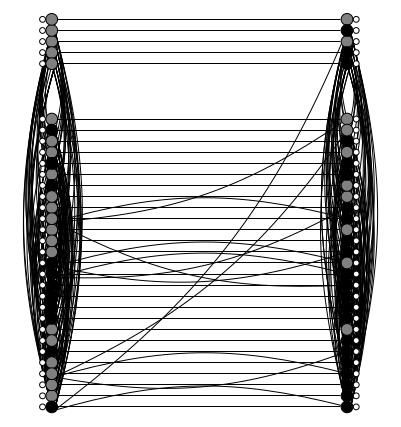

Cost at level 1, 242


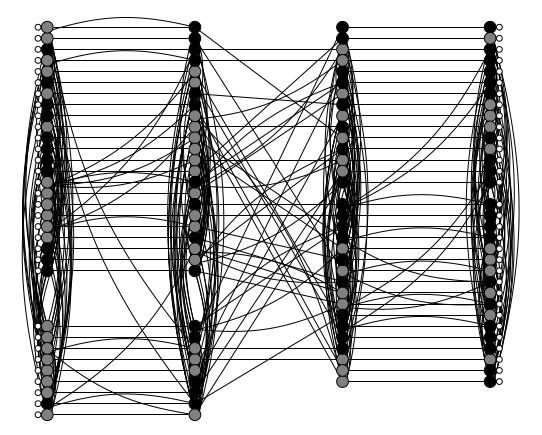

Cost at level 2, 228


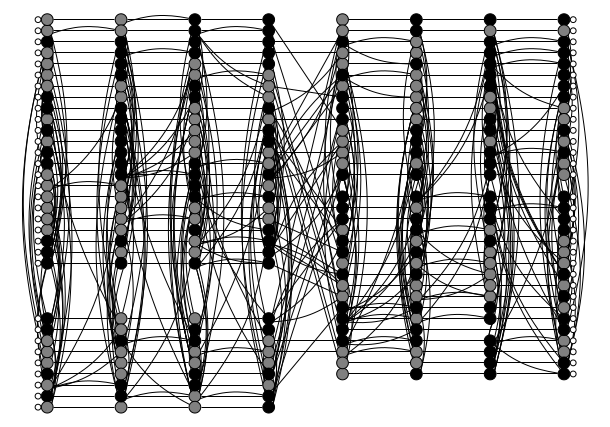

Cost at level 3, 228


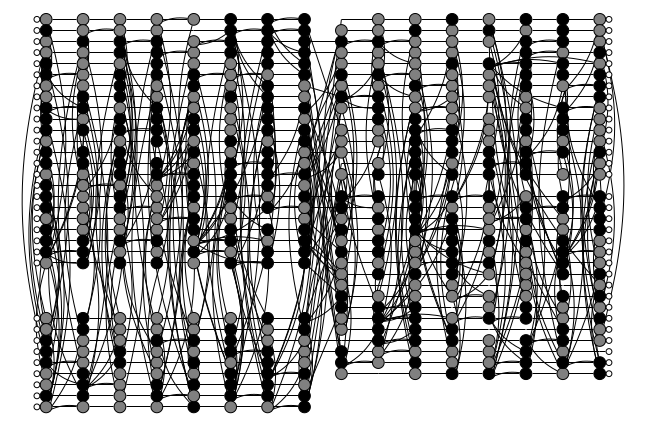

Cost at level 4, 228


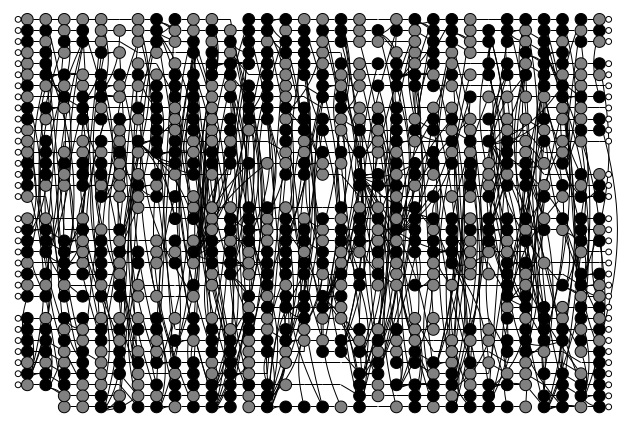

Cost at level 5, 214


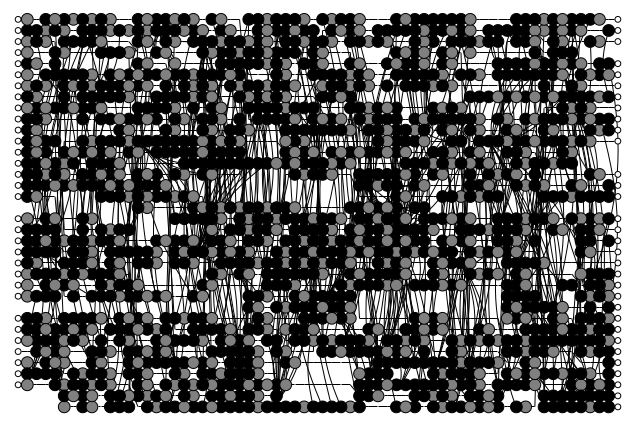

Cost at level 6, 214


In [58]:
initial_graph_recursive = graph.copy()
graph_list_recursive, mapping_list_recursive = coarsener.coarsen_recursive_batches(initial_graph_recursive)

assignment_list_recursive, cost_list_recursive, time_list_recursive = multilevel_FM(graph_list_recursive, mapping_list_recursive, assignment, qpu_sizes, limit=move_limit_per_pass, stochastic=exploratory)
i = 0

best_cost = min(cost_list_recursive)
total_time = sum(time_list_recursive)

print(f'Best cost: {best_cost}')
print(f'Total time: {total_time}')
print("Drawing figures")

for g in reversed(graph_list_recursive):
    fig = draw_graph_tikz(
        g,
        assignment_list_recursive[i],
        qpu_sizes
    )
    display(fig)
    print(f'Cost at level {i}, {cost_list_recursive[i]}')
    i += 1


[272, 242, 274, 248, 268, 241, 264, 247, 262, 244, 270, 240, 259, 244, 268, 244, 265, 246, 270, 248, 265, 247, 257, 243, 267, 247, 272, 246, 273, 246, 268, 252, 266, 240, 258, 236, 261, 238, 258, 251, 266, 249, 274, 247, 255, 246, 271, 247, 272, 251, 279, 250, 278, 247, 276, 248, 269, 248, 271, 247, 258, 246, 271, 243, 253, 238, 255, 245, 268, 240]
[0, 10, 20, 30, 40, 50, 60, 70]
[291, 244, 248, 246, 251, 251, 247, 240]


Text(0, 0.5, 'Cost')

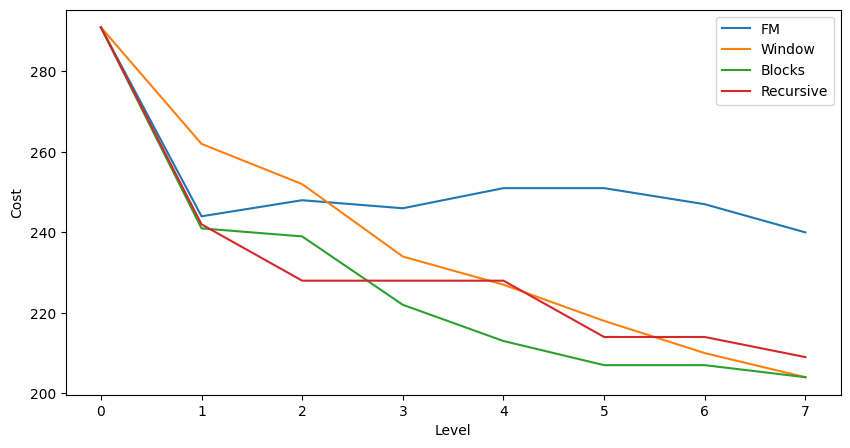

In [59]:
import matplotlib.pyplot as plt

print(cost_list)

cost_list = [initial_cost] + cost_list

index_list = [i*10 for i in range(level_limit+2)]
print(index_list)
cost_list_FM = [cost_list[i*10]for i in range(level_limit+2)]

print(cost_list_FM)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(cost_list_FM, label = 'FM')
plt.plot(cost_list_window, label = 'Window')
plt.plot(cost_list_blocks, label = 'Blocks')
plt.plot(cost_list_recursive, label = 'Recursive')

plt.legend()
plt.xlabel('Level')
plt.ylabel('Cost')

Text(0, 0.5, 'Time')

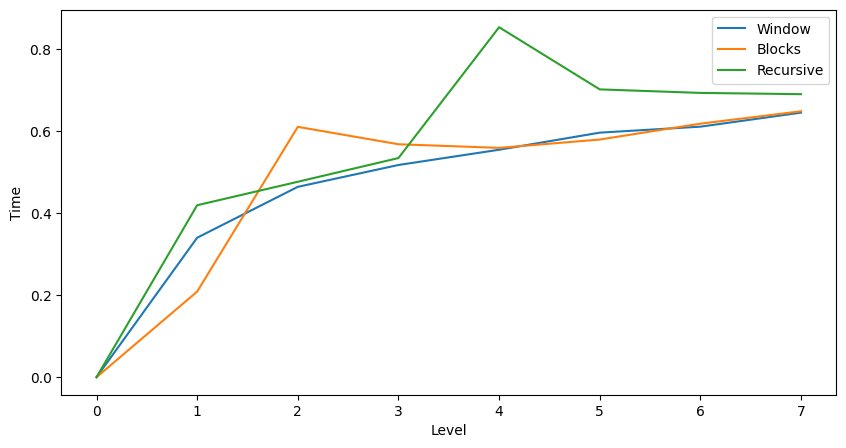

In [60]:
import matplotlib.pyplot as plt



fig, ax = plt.subplots(1, 1, figsize=(10, 5))

plt.plot(time_list_window, label = 'Window')
plt.plot(time_list_blocks, label = 'Blocks')
plt.plot(time_list_recursive, label = 'Recursive')

plt.legend()
plt.xlabel('Level')
plt.ylabel('Time')